In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pymer4.models import Lmer

In [2]:
df_h_path = 'df_with_features_h.csv'
df_g_path = 'df_with_features_g.csv'

df_with_features_h = pd.read_csv(df_h_path)
df_with_features_g = pd.read_csv(df_g_path)

In [3]:
def assign_time_segment(group):
    area = group['area_label'].astype(str).str.lower().to_numpy()
    selected = str(group['selected_answer_label'].iloc[0]).lower()
    target = f'answer_{selected}'

    mask = (area == target)
    n = len(group)
    out = np.full(n, 'before', dtype=object)

    if not mask.any():
        return pd.Series(out, index=group.index)

    first_pos = np.flatnonzero(mask)[0]

    out[first_pos:] = 'during'

    after_first = mask[first_pos + 1:]
    non_target_rel = np.flatnonzero(~after_first)

    if non_target_rel.size > 0:
        interruption = first_pos + 1 + non_target_rel[0]
        out[interruption:] = 'after'

    return pd.Series(out, index=group.index)


In [4]:
df_with_features_h['time_segment'] = (
    df_with_features_h
      .groupby(['participant_id', 'TRIAL_INDEX'], group_keys=False)
      .apply(assign_time_segment)
)

df_with_features_g['time_segment'] = (
    df_with_features_g
      .groupby(['participant_id', 'TRIAL_INDEX'], group_keys=False)
      .apply(assign_time_segment)
)



C:\Users\deeth\AppData\Local\Temp\ipykernel_10752\3461713398.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_features_h
C:\Users\deeth\AppData\Local\Temp\ipykernel_10752\3461713398.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_features_g


In [7]:
def comp_dwells_by_time(df):
    df_means = (
        df
        .groupby(['participant_id', 'TRIAL_INDEX', 'time_segment'])['IA_DWELL_TIME']
        .mean()
        .reset_index()
    )

    order = ['before', 'during', 'after']
    plt.figure(figsize=(8,6))
    sns.barplot(
        data=df_means,
        x='time_segment',
        y='IA_DWELL_TIME',
        order=order,
        estimator='mean',
        errorbar=('ci', 95)
    )
    plt.title("Mean dwell time by time segment")
    plt.xlabel("Time segment")
    plt.ylabel("Mean dwell time")
    plt.show()


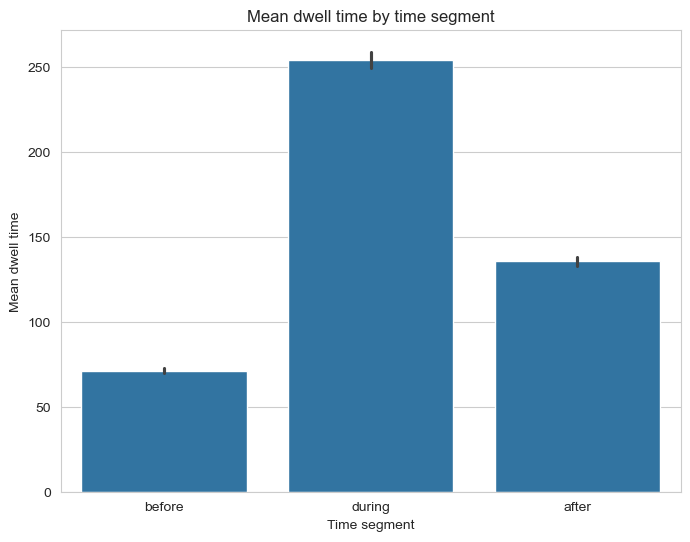

In [8]:
comp_dwells_by_time(df_with_features_h)

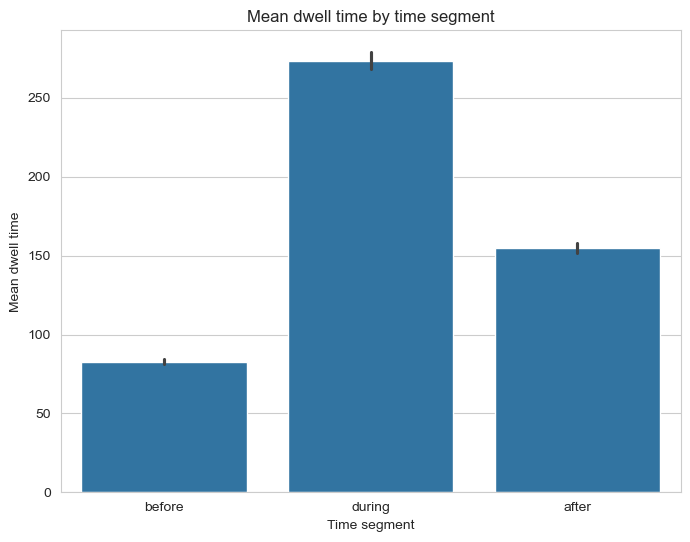

In [9]:
comp_dwells_by_time(df_with_features_g)

In [10]:
def counts_comp(df):
    df_counts = (
        df
        .groupby(['participant_id', 'TRIAL_INDEX', 'time_segment'])
        .size()
        .reset_index(name='count')
    )

    order = ['before', 'during', 'after']
    plt.figure(figsize=(8,6))
    sns.barplot(
        data=df_counts,
        x='time_segment',
        y='count',
        order=order,
        estimator='mean',
        errorbar=('ci', 95)
    )
    plt.title("Average sequence length (number of fixations) by time segment")
    plt.xlabel("Time segment")
    plt.ylabel("Average number of rows")
    plt.show()


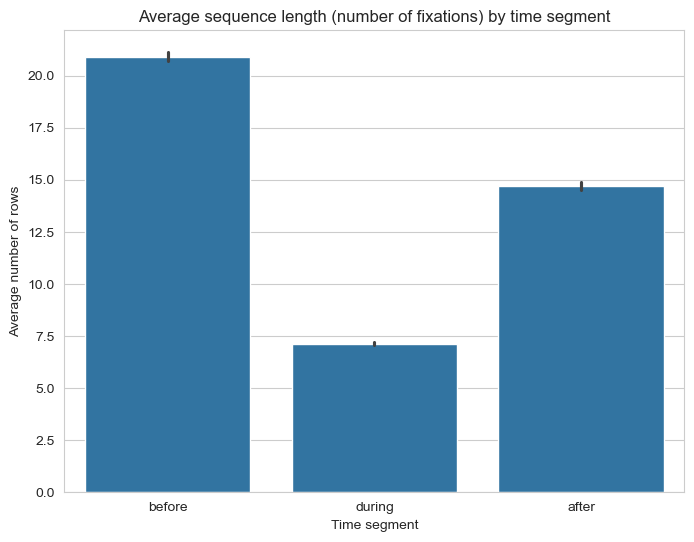

In [11]:
counts_comp(df_with_features_h)

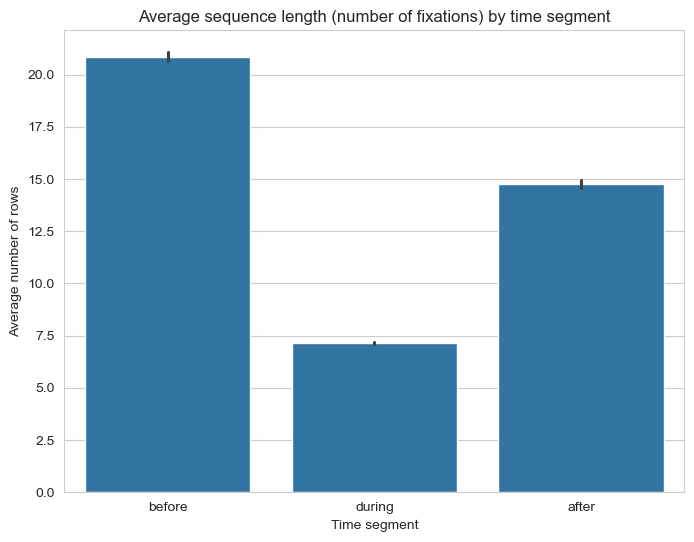

In [12]:
counts_comp(df_with_features_g)

In [13]:
def comp_fixations_counts_by_time(df):
    order = ['before', 'during', 'after']
    df['time_segment'] = pd.Categorical(df['time_segment'], categories=order, ordered=True)

    df_fix = (
        df
        .groupby(['participant_id', 'TRIAL_INDEX', 'time_segment'], observed=False)['IA_FIXATION_COUNT']
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8,6))
    sns.barplot(
        data=df_fix,
        x='time_segment',
        y='IA_FIXATION_COUNT',
        order=order,
        estimator='mean',
        errorbar=('ci', 95)
    )
    plt.title("Mean fixation count by time segment")
    plt.xlabel("Time segment")
    plt.ylabel("Mean fixation count")
    plt.show()


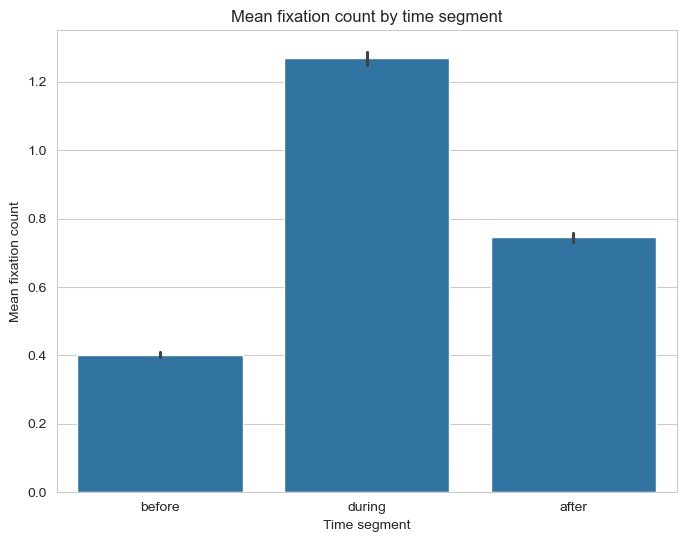

In [14]:
comp_fixations_counts_by_time(df_with_features_h)

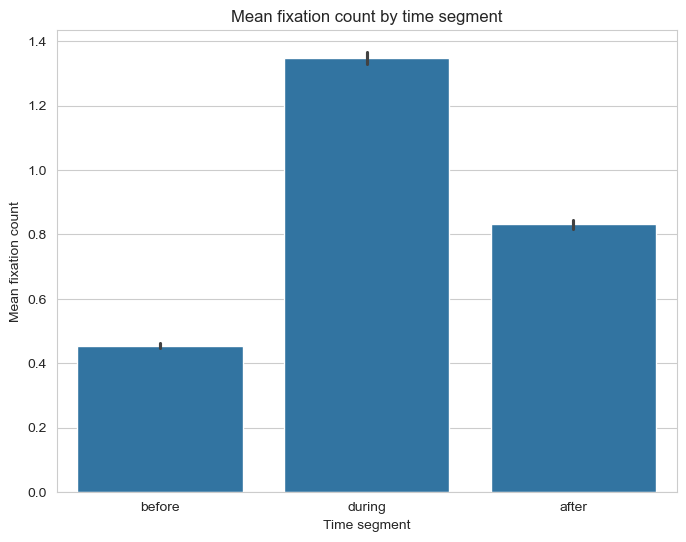

In [15]:
comp_fixations_counts_by_time(df_with_features_g)

In [16]:
def comp_skip_rates_by_time(df):
    order = ['before', 'during', 'after']
    df['time_segment'] = pd.Categorical(df['time_segment'], categories=order, ordered=True)

    df = df.copy()
    df['skipped'] = (df['IA_DWELL_TIME'] == 0).astype(int)

    df_skips = (
        df.groupby(['participant_id', 'TRIAL_INDEX', 'time_segment'], observed=True)['skipped']
        .mean()
        .reset_index(name='skip_rate')
    )

    plt.figure(figsize=(8,6))
    sns.barplot(
        data=df_skips,
        x='time_segment',
        y='skip_rate',
        order=order,
        estimator='mean',
        errorbar=('ci', 95)
    )
    plt.title("Mean skip rate by time segment")
    plt.xlabel("Time segment")
    plt.ylabel("Skip rate (proportion)")
    plt.ylim(0, 1)
    plt.show()


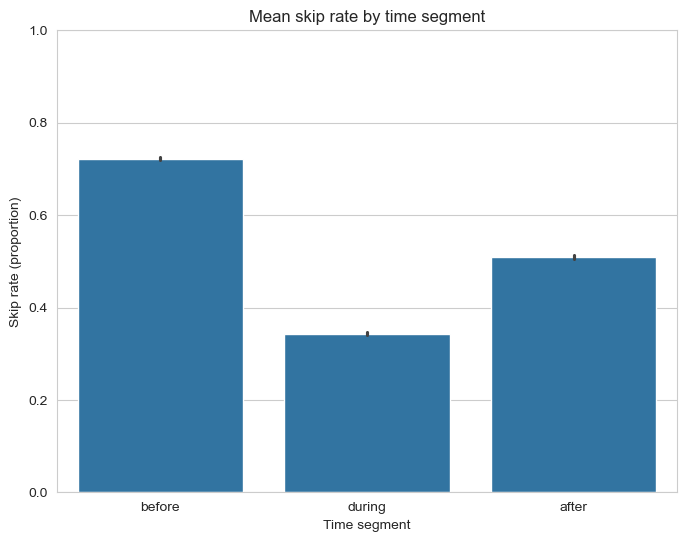

In [17]:
comp_skip_rates_by_time(df_with_features_h)

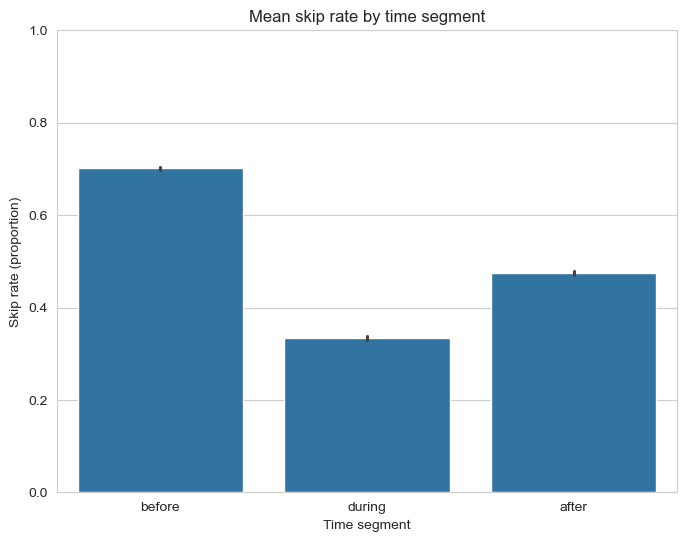

In [18]:
comp_skip_rates_by_time(df_with_features_g)

In [ ]:
#throw selected fixations out of after